In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import maximum_filter, convolve
from matplotlib.colors import LogNorm
plt.style.use('../tools/radioSphere.mplstyle')
%matplotlib inline

import matplotlib
# matplotlib.rcParams['text.latex.preamble'] = '\\renewcommand{\\vec}[1]{\\underline{#1}};\\newcommand{\\im}[1]{\\underline{\\underline{#1}}}'
matplotlib.rcParams['text.latex.preamble'] = '\\renewcommand{\\vec}[1]{\\mathbf{#1}}\n\\newcommand{\\im}[1]{#1}'

single_column_width = 3.2872828 # 236.6843 pt in inches, for MST manuscript
double_column_width = 6.7753125 # 487.8225 pt in inches, for MST manuscript
golden_ratio = (1 + np.sqrt(5))/2.

In [21]:
def single_particle_projection(x, y, x_detector, y_detector, a):
    # This function returns the parallel projection (dims of x_detector) of particles positioned at x and y
    psi = a*np.sqrt(r**2 - (x - x_detector)**2 - (y - y_detector)**2)
    psi[np.isnan(psi)] = 0.
    # psi = np.exp(-((x-x_detector)/r)**2)
    return psi

# non-naiive approach
def PI_projector(f):
    g = f.copy()
    g[f<0.5] = 0.
    g[g.imag < 1e-14] = np.round(g[g.imag < 1e-14])
    # g.real = np.round(g.real)
    # g = np.round(g) # NOTE: Should this have an abs?
    # g = np.round(np.abs(g)) # NOTE: Should this have an abs?
    return g

# Bottom of page 8 in TomoPack.pdf --- just take peaks in a 3x3 pixel area, and weight by all of the mass in that area
def filter_maxima(f,debug=False):
    f_abs = np.abs(f)
    f_abs[f<0] = 0
    g = maximum_filter(f_abs,size=3)
    peaks = f_abs == g
    masses = convolve(f_abs,[[1,1,1],[1,1,1],[1,1,1]])
    if debug:
        plt.imshow(np.real(f))
        plt.title('real part of original estimation')
        plt.colorbar()
        plt.show()
        plt.imshow(f_abs)
        plt.title('positive real component')
        plt.colorbar()
        plt.show()
        plt.imshow(g)
        plt.colorbar()
        plt.title('Local filtered maxima')
        plt.show()
        plt.imshow(peaks)
        plt.colorbar()
        plt.title('Location of local peaks')
        plt.show()
        plt.imshow(masses)
        plt.colorbar()
        plt.title('Local masses')
        plt.show()
        plt.imshow(peaks*masses)
        plt.colorbar()
        plt.title('Final weighted estimation')
        plt.show()
    return peaks*masses

# Make convolution example

<ipython-input-21-550d8b7010cc>:3: RuntimeWarning: invalid value encountered in sqrt
  psi = a*np.sqrt(r**2 - (x - x_detector)**2 - (y - y_detector)**2)


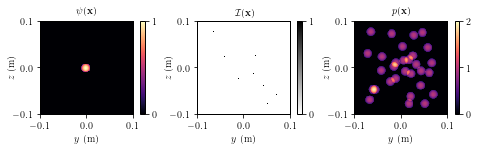

In [22]:
nx = 201
ny = 201
L = 0.1
x = np.linspace(-L,L,nx)
y = np.linspace(-L,L,ny)
x_plot = np.linspace(-L,L,nx+1)
y_plot = np.linspace(-L,L,nx+1)
X,Y = np.meshgrid(x,y,indexing='ij')
x_true = []
y_true = []
r = 0.01
a = 1./r
N = 30

np.random.seed(seed=0)
# xp = 2*np.random.rand(N,2) - 1

p = np.zeros([nx,ny])
I = np.zeros([nx,ny])
psi = single_particle_projection(0,0,X,Y,a)
pad = 2*r
for i in range(N):
    x_loc = 2*(L-pad)*np.random.rand() - (L - pad)
    y_loc = 2*(L-pad)*np.random.rand() - (L - pad)
    x_index = int((x_loc + L)/(2*L)*nx)
    y_index = int((y_loc + L)/(2*L)*ny)
    I[x_index,y_index] += 1
    p += single_particle_projection(x_loc,y_loc,X,Y,a)
    x_true.append(x_loc)
    y_true.append(y_loc)
    
plt.close('all')
aspect_ratio = 3.5
fig = plt.figure(figsize=[double_column_width,double_column_width/aspect_ratio])

ax = plt.subplot(131)
plt.title(r'$\im{\psi}(\vec{x})$', pad=7)
plt.pcolormesh(x_plot,y_plot,psi,rasterized=True)
plt.xticks([-L,0,L])
plt.yticks([-L,0,L])
plt.xlabel(r'$y$ (m)')
plt.ylabel(r'$z$ (m)',labelpad=-5)
plt.gca().set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax=ax,cax=cax,ticks=[0,1])
# cbar.ax.set_yticklabels(['0','0.01'])
# plt.colorbar()

ax = plt.subplot(132)
plt.title(r'$\im{\mathcal{I}}(\vec{x})$', pad=5)
plt.pcolormesh(x_plot,y_plot,I,rasterized=True,cmap='gray_r')
plt.xticks([-L,0,L])
plt.yticks([-L,0,L])
plt.xlabel(r'$y$ (m)')
plt.ylabel(r'$z$ (m)',labelpad=-5)
plt.gca().set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(ax=ax,cax=cax,ticks=[0,1])

ax = plt.subplot(133)
plt.title(r'$\im{p}(\vec{x})$', pad=7)
plt.pcolormesh(x_plot,y_plot,p,rasterized=True,vmin=0,vmax=2)
plt.xticks([-L,0,L])
plt.yticks([-L,0,L])
plt.xlabel(r'$y$ (m)')
plt.ylabel(r'$z$ (m)',labelpad=-5)
plt.gca().set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(ax=ax,cax=cax,ticks=[0,1,2,3])


plt.subplots_adjust(left=0.08,right=0.94,bottom=0.22,top=0.90,wspace=0.5)
plt.savefig('convolution_example.pdf')

# Make FFT example

In [23]:
epsilon = 0.1 # trust cutoff in psi
l = 0.1 # lambda, relaxation parameter

p_FFT = np.fft.fft2(p)
psi_FFT = np.fft.fft2(psi)

# Prepare for iterations
f_x = np.zeros_like(X)
f_x_old = epsilon*np.ones_like(X)
k_trust = np.abs(psi_FFT) > epsilon
f_k_naiive = p_FFT/psi_FFT
f_x_naiive = np.fft.ifft2(f_k_naiive)

count = 0
errs = []

while np.linalg.norm(f_x - f_x_old) > 1e-3: # NOTE: Using a different epsilon here
    errs.append(np.linalg.norm(f_x - f_x_old))
    f_x_old = f_x.copy()
    f_k = np.fft.fft2(f_x)
    f_k[k_trust] = f_k_naiive[k_trust]
    f_x = np.fft.fftshift(np.fft.ifft2(f_k)) # importing HACK from 1D version
    f_x = f_x + l*(PI_projector(f_x) - f_x)
    count += 1
    if count > 1000:
        print('KILLED LOOP')
        break
print('Took ' + str(count) + ' iterations to complete.')

f_x = filter_maxima(f_x,debug=False)

# divergence from 1D script, organise image to find highest N points
indicesFlat = np.argpartition(f_x, -N, axis=None)[-N:]
# Turn it back into 2D coordinates -- Eddy version of np.unravel_index(indices, ary.shape)
p_predicted = np.zeros((N,2), dtype=int)
p_predicted[:,0] = indicesFlat % X.shape[1]
p_predicted[:,1] = indicesFlat //  X.shape[1]

not_k_trust_ind = np.where(~k_trust)

one_on_psi_plot = 1./np.abs(psi_FFT)
one_on_psi_plot[~k_trust] = np.nan

p_f_x = np.zeros_like(X, dtype=float)
for i in range(N):
    #print(x_detector[p_predicted[i,0], p_predicted[i,1]])
    #print(x_detector[p_predicted[i]], y_detector[p_predicted[i]])
    p_f_x += single_particle_projection(X[p_predicted[i,1], p_predicted[i,0]], Y[p_predicted[i,1], p_predicted[i,0]],
                                        X, Y, a)
residual = p_f_x - p

p_true = np.vstack([x_true,y_true]).T
p_predMM = np.vstack([x[p_predicted[:,1]],y[p_predicted[:,0]]]).T

from scipy.spatial import distance
distances = distance.cdist(p_true,p_predMM)
distance_threshold = r

# an empty column in the distance matrix is a lost particle
number_lost = np.sum((np.sum(distances <= distance_threshold, axis=0) == 0))
if number_lost > 0: print(f"detectSpheres.calculateErrors(): number_lost = {number_lost}")

# get errors
min_errors = np.min(distances, axis=0) # best match for each column
min_valid_errors = min_errors[min_errors < distance_threshold] # just where we found a particle
dx = x[1] - x[0]
print(f'Worst particle match is {(min_errors/dx).max()} pixels')

Took 49 iterations to complete.
Worst particle match is 0.6865809128759589 pixels


<ipython-input-21-550d8b7010cc>:3: RuntimeWarning: invalid value encountered in sqrt
  psi = a*np.sqrt(r**2 - (x - x_detector)**2 - (y - y_detector)**2)


In [34]:
aspect_ratio = 2.
plt.figure(figsize=[double_column_width,double_column_width/aspect_ratio])
title_pad = 5

k = np.fft.fftshift(np.fft.fftfreq(nx))#,x[1] - x[0]))
k *= 200 # signal length
dk = k[1] - k[0]
k_plot = np.hstack([k[0]-dk/2,k+dk])

ax = plt.subplot(231)
plt.pcolormesh(k_plot,k_plot,np.abs(np.fft.fftshift(p_FFT)), norm=LogNorm(vmin=1e-3, vmax=1e3), rasterized=True)
# plt.xticks([-L,0,L])
# plt.yticks([-L,0,L])
plt.xlabel(r'$k_y$ (px)')
plt.ylabel(r'$k_z$ (px)',labelpad=-5)
plt.gca().set_aspect('equal')
plt.title(r'$|\im{\tilde{p}}(\vec{k})|$',pad=title_pad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(ax=ax,cax=cax,ticks=[1e-3,1e0,1e3])
# cb.set_label(r'$|\tilde{p}(k)|$',rotation=0,y=0.75,labelpad=-5)

ax = plt.subplot(232)
plt.pcolormesh(k_plot,k_plot,np.abs(np.fft.fftshift(psi_FFT)), norm=LogNorm(vmin=1e-3, vmax=1e3), rasterized=True)
# plt.xticks([-L,0,L])
# plt.yticks([-L,0,L])
plt.xlabel(r'$k_y$ (px)')
plt.ylabel(r'$k_z$ (px)',labelpad=-5)
plt.gca().set_aspect('equal')
plt.title(r'$|\im{\tilde{\psi}}(\vec{k})|$',pad=title_pad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(ax=ax,cax=cax,ticks=[1e-3,1e0,1e3])
# cb.set_label(r'$|\tilde{\psi}(k)|$',rotation=0,y=1,labelpad=8)


ax = plt.subplot(233)
# plt.imshow(one_on_psi_plot, norm=LogNorm())
plt.pcolormesh(k_plot,k_plot,1./np.abs(np.fft.fftshift(psi_FFT)), norm=LogNorm(vmin=1e-3, vmax=1e3), rasterized=True)
# plt.semilogy(np.arange(len(psi_FFT))[k_trust],1./np.abs(psi_FFT)[k_trust],'g.')
#plt.semilogy(np.arange(len(psi_FFT))[~k_trust],1./np.abs(psi_FFT)[~k_trust],'r.')
#plt.semilogy([0,len(psi_FFT)],[1./epsilon,1./epsilon],'k--')
# plt.plot(not_k_trust_ind[0], not_k_trust_ind[1], 'r.')
# plt.xticks([-L,0,L])
# plt.yticks([-L,0,L])
plt.xlabel(r'$k_y$ (px)')
plt.ylabel(r'$k_z$ (px)',labelpad=-5)
plt.gca().set_aspect('equal')
plt.title(r'$|\im{\tilde{\psi}}(\vec{k})|^{-1}$',pad=title_pad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(ax=ax,cax=cax,ticks=[1e-3,1e0,1e3])
# cb.set_label(r'$|\tilde{\psi}(k)|^{-1}$',rotation=0,y=1.1,labelpad=-5)

# plt.ylim(0,1./epsilon)

#plt.subplot(337)
#plt.title(r'Naiive $\tilde{f}(k)=\tilde{p}(k)/\tilde{\psi}(k)$')
#plt.imshow(np.real(f_k_naiive))
##plt.ylim(-30,30)

ax = plt.subplot(234)
plt.pcolormesh(k_plot,k_plot,np.fft.fftshift(k_trust), rasterized=True, cmap='gray_r')# norm=LogNorm(vmin=1e-2, vmax=1e2))
# plt.xticks([-L,0,L])
# plt.yticks([-L,0,L])
plt.xlabel(r'$k_y$ (px)')
plt.ylabel(r'$k_z$ (px)',labelpad=-5)
plt.gca().set_aspect('equal')
plt.title(r'$\im{K_{trust}}(\vec{k})$',pad=title_pad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(ax=ax,cax=cax,ticks=[0,1])
# cb.set_label(r'$|\tilde{f}(k)|$',rotation=0,y=1.1,labelpad=-10)

# plt.plot(np.arange(len(f_k))[k_trust],np.real(f_k)[k_trust],'g.')
#plt.plot(np.arange(len(f_k))[~k_trust],np.real(f_k)[~k_trust],'r.')
# plt.plot(not_k_trust_ind[0], not_k_trust_ind[1], 'r.')
#plt.ylim(-30,30)

ax = plt.subplot(235)
plt.pcolormesh(x_plot,y_plot,PI_projector(f_x), rasterized=True, cmap='gray_r')
#plt.plot(x_detector,PI_projector(f_x),'.')
# plt.plot(p_predicted[:,0], p_predicted[:,1], 'o', mec='r', mfc='None', mew=0.1)
plt.xticks([-L,0,L])
plt.yticks([-L,0,L])
plt.xlabel(r'$y$ (m)')
plt.ylabel(r'$z$ (m)',labelpad=-5)
plt.gca().set_aspect('equal')
plt.title(r'$\im{\Pi}[f(\vec{x})]$',pad=title_pad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(ax=ax,cax=cax,ticks=[0,1])
# cb.set_label(r'$\Pi[f(x)]$',rotation=0,y=0.85,labelpad=0)


ax = plt.subplot(236)
vmax = np.abs(residual).max()
plt.pcolormesh(x_plot,y_plot,residual, vmin=-vmax, vmax=vmax, cmap='bwr', rasterized=True)
plt.xticks([-L,0,L])
plt.yticks([-L,0,L])
plt.xlabel(r'$y$ (m)')
plt.ylabel(r'$z$ (m)',labelpad=-5)
plt.gca().set_aspect('equal')
plt.title(r'$\im{e}(\vec{x})$ (mm)',pad=title_pad)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(ax=ax,cax=cax)
# cb.set_label(r'$e$',rotation=0,y=1.1,labelpad=-25)



plt.subplots_adjust(left=0.071,right=0.93,bottom=0.117,top=0.94,wspace=1,hspace=0.5)
plt.savefig('FFT_example.pdf')
# plt.show()

print('Done')

Done


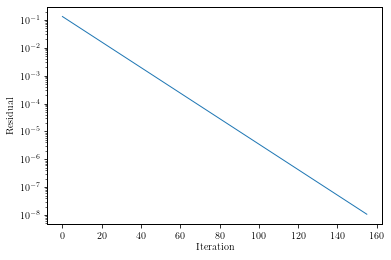

In [81]:
%matplotlib inline
e = errs[2:]
plt.semilogy(np.arange(len(e)),e)
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.savefig('FFT_iterations.pdf')

In [4]:
theta = np.linspace(0,np.pi/2,501)
phi = np.linspace(0,np.pi/2,501)
Theta,Phi = np.meshgrid(theta,phi)

plt.figure(figsize=[single_column_width,single_column_width/golden_ratio])

# aspect = np.sin(np.pi/2. + Phi)/np.sin(np.pi/2. - Theta - Phi)
# aspect = 2*np.cos(Phi)/(np.cos(Theta + Phi) + np.cos(Theta - Phi))
aspect = 1./np.cos(Theta)
# projectedAspectRatio = 2*numpy.cos(halfBeamAngle)/(numpy.cos(alpha+halfBeamAngle)+numpy.cos(alpha-halfBeamAngle)) # Stephane's version
# aspect[aspect<0] = np.nan
# aspect[aspect>10] = np.nan
# aspect[(aspect<1.0001)*(aspect>0.9999)] = 1
plt.pcolormesh(np.degrees(theta),np.degrees(phi),aspect,vmin=1,vmax=1e1,norm=LogNorm(),rasterized=True)
levels = np.linspace(1,2,5)
# levels = np.logspace(0,1,5)
# levels = [1,2,3,5,10]
# plt.contour(Alpha,Phi,aspect,levels=levels)
cb = plt.colorbar(ticks=[1,2,3,4,5,6,10])
cb.ax.set_yticklabels([1,2,3,4,5,6,10])  # vertically oriented colorbar
plt.minorticks_off()
cb.set_label('$\mathrm{AR}$ (-)')

plt.xlabel(r'$\theta$ (degrees)',labelpad=0)
plt.ylabel(r'$\phi$ (degrees)',labelpad=2)
plt.xticks([0,20,40,60])
plt.yticks([0,30,60,90])

plt.subplots_adjust(left=0.13,bottom=0.18,top=0.97,right=0.95)
plt.savefig('projectedParticleAspectRatio.pdf')

<ipython-input-4-3266b04c0601>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.degrees(theta),np.degrees(phi),aspect,vmin=1,vmax=1e1,norm=LogNorm(),rasterized=True)
<ipython-input-4-3266b04c0601>:14: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.pcolormesh(np.degrees(theta),np.degrees(phi),aspect,vmin=1,vmax=1e1,norm=LogNorm(),rasterized=True)
